# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target                  |  Data Type       | Description                     |
|-------------------------|------------------|---------------------------------|
| next_week_sales_target  |   float64        | Sales in USD per week by store  |


| Column Name             |  Data Type        | Description                                                     |  
|:------------------------|:------------------|:----------------------------------------------------------------|
| store_id                |   int64           | unique identifier for store  (1-45)                             |
| Temperature             |   float64         | temperature in Farenheight                                      |
| Fuel_Price              |   float64         | cost of fuel(in USD) in region                                  | 
| CPI                     |   float64         | Prevailing consumer price index, cost of goods                  |
| this_week_date          |   datetime64[ns]  | date for current week                                           |
| this_week_sales         |   float64         | sales in USD for current week                                   |     
| this_week_holiday_flag  |   int64           | indicator of a Holiday for current week (boolean)               |
| this_week_unemployment  |   float64         | unemployment rate for current week                              |     
| store_type              |   object          | A: SuperStore, B: Walmart, C: neighborhood Walmart              |
| store_size              |   int64           | size of specific location in sqft                               |
| next_week_1_year_ago    |   float64         | sales for following week of previous year (51 weeks ago)        |
| next_week_date          |   datetime64[ns]  | the date of the following week                                  |
| next_week_holiday_flag  |   float64         | indicator of a Holiday for following week (boolean)             |
| next_week_holiday_name  |   object          | name of holiday for following week                              |  
| christmas               |   uint8           | indicator of Christmas (boolean)                                |     
| labor_day               |   uint8           | indicator of labor day (boolean)                                |    
| pre_christmas           |   uint8           | indicator of pre-christmas: 2 weeks prior to christmas (boolean)|     
| super_bowl              |   uint8           | indicator of super bowl (boolean)                               |     
| thanksgiving            |   uint8           | indicator of Thanksgiving (boolean)                             |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#math
from scipy import stats
import math

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

#custom modules
import new_wrangle as w

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#bring in walmart data using new_wrangle.py
df= w.acquire_data()

In [3]:
#take a look
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= w.wrangle_walmart()

In [6]:
#make sure that all columns are created
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 2010-02-05_store_1_2010-02-12 to 2012-10-26_store_45_nan
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   store_id                 6435 non-null   object        
 1   this_week_date           6435 non-null   datetime64[ns]
 2   this_week_sales          6435 non-null   float64       
 3   this_week_holiday_flag   6435 non-null   int64         
 4   temperature              6435 non-null   int64         
 5   fuel_price               6435 non-null   float64       
 6   CPI                      6435 non-null   float64       
 7   this_week_unemployment   6435 non-null   float64       
 8   store_type               6435 non-null   object        
 9   store_size               6435 non-null   int64         
 10  next_week_1_year_ago     4140 non-null   float64       
 11  next_week_sales_target   6390 non-null   float64     

In [7]:
#take a look at the data
df.tail().T

id,2012-09-28_store_45_2012-10-05,2012-10-05_store_45_2012-10-12,2012-10-12_store_45_2012-10-19,2012-10-19_store_45_2012-10-26,2012-10-26_store_45_nan
store_id,45,45,45,45,45
this_week_date,2012-09-28 00:00:00,2012-10-05 00:00:00,2012-10-12 00:00:00,2012-10-19 00:00:00,2012-10-26 00:00:00
this_week_sales,713174,733455,734464,718126,760281
this_week_holiday_flag,0,0,0,0,0
temperature,64,64,54,56,58
fuel_price,4,3.98,4,3.97,3.88
CPI,192.014,192.17,192.327,192.331,192.309
this_week_unemployment,8.684,8.667,8.667,8.667,8.667
store_type,B,B,B,B,B
store_size,118221,118221,118221,118221,118221


In [8]:
df.isnull().sum()

store_id                      0
this_week_date                0
this_week_sales               0
this_week_holiday_flag        0
temperature                   0
fuel_price                    0
CPI                           0
this_week_unemployment        0
store_type                    0
store_size                    0
next_week_1_year_ago       2295
next_week_sales_target       45
next_week_date               45
next_week_holiday_flag       45
next_week_season           2340
this_week_season           2340
next_week_holiday_name        0
christmas                     0
labor_day                     0
pre_christmas                 0
super_bowl                    0
thanksgiving                  0
fuel_4wk_rolling              3
cpi_4wk_rolling               3
unemp_4wk_rolling             3
avgMoM_perc_fuel              7
avgMoM_perc_cpi               7
avgMoM_perc_unemp             7
fuel_quarterly_rolling       11
cpi_quarterly_rolling        11
unemp_quarterly_rolling      11
avgQoQ_p

In [9]:
#train test split
train, test = w.split_scale(df,'next_week_sales_target')

train -> (2866, 34)
test -> (1229, 34)


In [10]:
#take a look
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 2010-02-05_store_1_2010-02-12 to 2012-10-26_store_45_nan
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   store_id                 6435 non-null   object        
 1   this_week_date           6435 non-null   datetime64[ns]
 2   this_week_sales          6435 non-null   float64       
 3   this_week_holiday_flag   6435 non-null   int64         
 4   temperature              6435 non-null   int64         
 5   fuel_price               6435 non-null   float64       
 6   CPI                      6435 non-null   float64       
 7   this_week_unemployment   6435 non-null   float64       
 8   store_type               6435 non-null   object        
 9   store_size               6435 non-null   int64         
 10  next_week_1_year_ago     4140 non-null   float64       
 11  next_week_sales_target   6390 non-null   float64     

<hr style="border:2px solid black"> </hr>

# Explore

In [11]:
#count of season
#train.season.value_counts()

In [12]:
#counts by holidays
train.next_week_holiday_name.value_counts()

no_holiday       2615
labor_day          66
super_bowl         63
pre_christmas      60
thanksgiving       31
christmas          31
Name: next_week_holiday_name, dtype: int64

## bivariate exploration

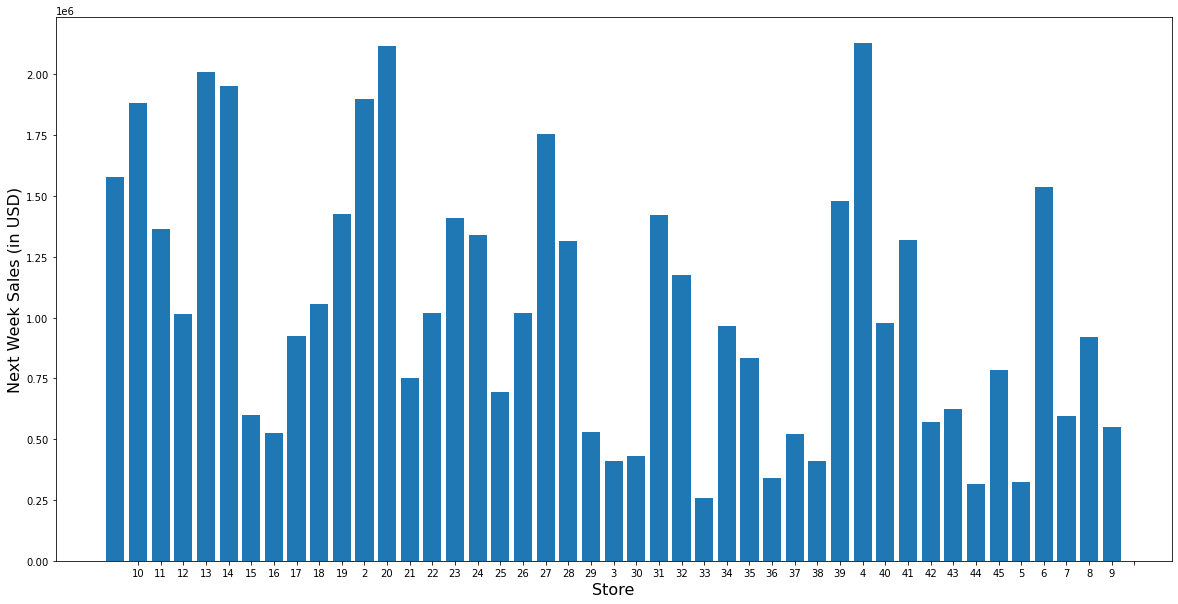

In [13]:
#average weekly sales by store
stores = train.groupby(['store_id']).agg({'next_week_sales_target': ['mean']})

plt.figure(figsize=(20, 10))
plt.bar(stores.index,stores['next_week_sales_target']['mean'])
plt.xticks(np.arange(1, 46, step=1))
plt.ylabel('Next Week Sales (in USD)', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

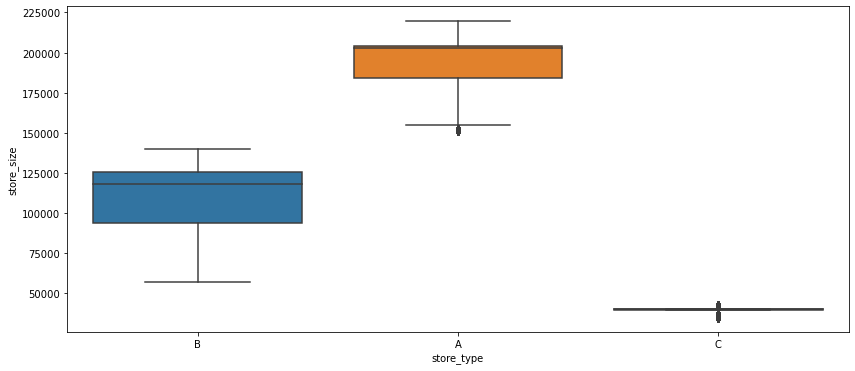

In [14]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=train)

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

- outliers were addressed (store 3, store 5, store 33, store 36 were classified incorrectly)

<AxesSubplot:xlabel='store_type', ylabel='next_week_sales_target'>

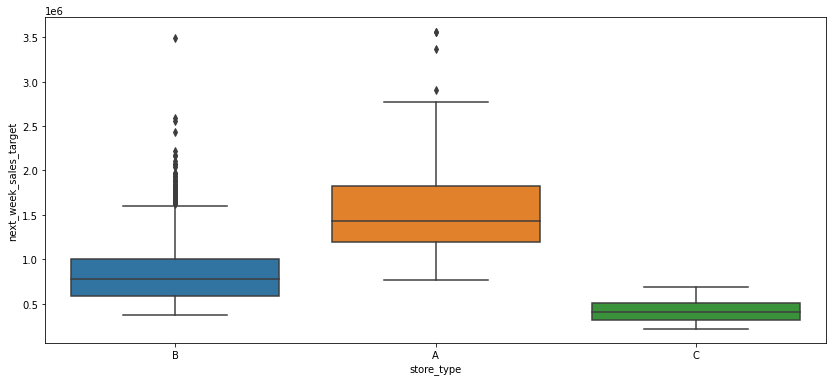

In [15]:
#visualize stores and weekly sales
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='next_week_sales_target', data=train)

<AxesSubplot:xlabel='store_type', ylabel='this_week_unemployment'>

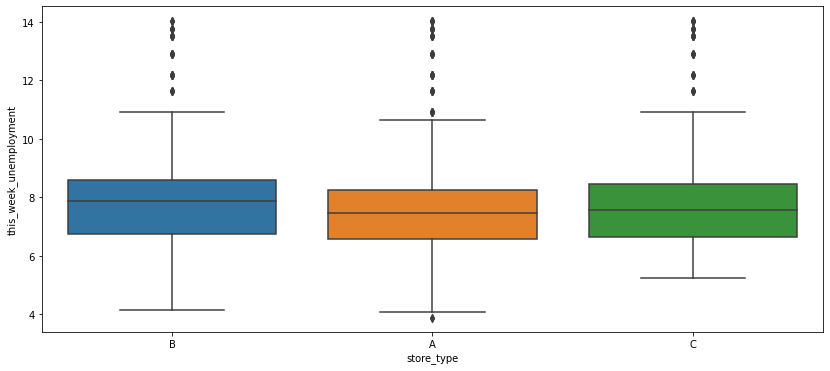

In [16]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='this_week_unemployment', data=train)

In [17]:
walmart = train.corr()
walmart

,this_week_sales,this_week_holiday_flag,temperature,fuel_price,CPI,this_week_unemployment,store_size,next_week_1_year_ago,next_week_sales_target,next_week_holiday_flag,...,unemp_4wk_rolling,avgMoM_perc_fuel,avgMoM_perc_cpi,avgMoM_perc_unemp,fuel_quarterly_rolling,cpi_quarterly_rolling,unemp_quarterly_rolling,avgQoQ_perc_fuel,avgQoQ_perc_cpi,avgQoQ_perc_unemp
this_week_sales,1.000000,0.045091,-0.066168,-0.000779,-0.068394,-0.124278,0.822618,0.946883,0.962765,0.046326,...,-0.125773,-0.035517,-0.022917,0.024188,0.025420,-0.068389,-0.127142,-0.024507,0.022682,-0.040740
this_week_holiday_flag,0.045091,1.000000,-0.120118,-0.125995,-0.009749,-0.000009,-0.005686,-0.002272,0.000464,-0.071402,...,-0.003344,-0.018413,-0.006828,0.047695,-0.114599,-0.009910,-0.002807,-0.204626,-0.088187,-0.017505
temperature,-0.066168,-0.120118,1.000000,0.282312,0.194927,0.104650,-0.097446,-0.067811,-0.066468,-0.107738,...,0.104953,-0.214160,-0.350023,0.071314,0.466041,0.198628,0.100705,0.094408,-0.078804,0.072932
fuel_price,-0.000779,-0.125995,0.282312,1.000000,-0.369042,0.200355,0.029195,0.020143,0.005592,-0.180510,...,0.196294,0.346798,-0.152638,0.225360,0.739653,-0.368048,0.185975,0.352177,0.109540,0.093908
CPI,-0.068394,-0.009749,0.194927,-0.369042,1.000000,-0.259608,-0.020276,-0.072945,-0.067191,0.014123,...,-0.259602,-0.008442,0.195721,-0.014211,-0.364749,0.999958,-0.260137,-0.013148,0.169723,0.031083
this_week_unemployment,-0.124278,-0.000009,0.104650,0.200355,-0.259608,1.000000,-0.071430,-0.097472,-0.123025,0.005452,...,0.999223,0.022924,0.001452,0.118732,0.184442,-0.260102,0.997736,0.073604,0.013824,0.243356
store_size,0.822618,-0.005686,-0.097446,0.029195,-0.020276,-0.071430,1.000000,0.815440,0.826692,-0.002286,...,-0.073134,0.001814,0.006028,0.046786,0.026267,-0.020298,-0.076749,0.003934,0.025083,0.083024
next_week_1_year_ago,0.946883,-0.002272,-0.067811,0.020143,-0.072945,-0.097472,0.815440,1.000000,0.986895,0.022338,...,-0.100236,-0.013943,-0.006005,0.030425,0.037336,-0.073069,-0.102067,0.004116,0.029291,0.002494
next_week_sales_target,0.962765,0.000464,-0.066468,0.005592,-0.067191,-0.123025,0.826692,0.986895,1.000000,0.035292,...,-0.125143,-0.023049,-0.018228,0.010336,0.027169,-0.067206,-0.125939,-0.016706,0.022188,-0.030810
next_week_holiday_flag,0.046326,-0.071402,-0.107738,-0.180510,0.014123,0.005452,-0.002286,0.022338,0.035292,1.000000,...,0.002109,-0.022358,0.005758,-0.028500,-0.145748,0.013888,0.004924,-0.195369,-0.074303,-0.005612


In [18]:
#this shows correlation with sales
wal_corr = walmart['next_week_sales_target'].sort_values(ascending=False)
wal_corr

next_week_sales_target     1.000000
next_week_1_year_ago       0.986895
this_week_sales            0.962765
store_size                 0.826692
pre_christmas              0.112758
thanksgiving               0.063746
next_week_holiday_flag     0.035292
fuel_quarterly_rolling     0.027169
avgQoQ_perc_cpi            0.022188
fuel_4wk_rolling           0.015321
super_bowl                 0.015225
avgMoM_perc_unemp          0.010336
fuel_price                 0.005592
christmas                  0.003227
this_week_holiday_flag     0.000464
labor_day                 -0.002386
avgQoQ_perc_fuel          -0.016706
avgMoM_perc_cpi           -0.018228
avgMoM_perc_fuel          -0.023049
avgQoQ_perc_unemp         -0.030810
temperature               -0.066468
cpi_4wk_rolling           -0.067162
CPI                       -0.067191
cpi_quarterly_rolling     -0.067206
this_week_unemployment    -0.123025
unemp_4wk_rolling         -0.125143
unemp_quarterly_rolling   -0.125939
Name: next_week_sales_target

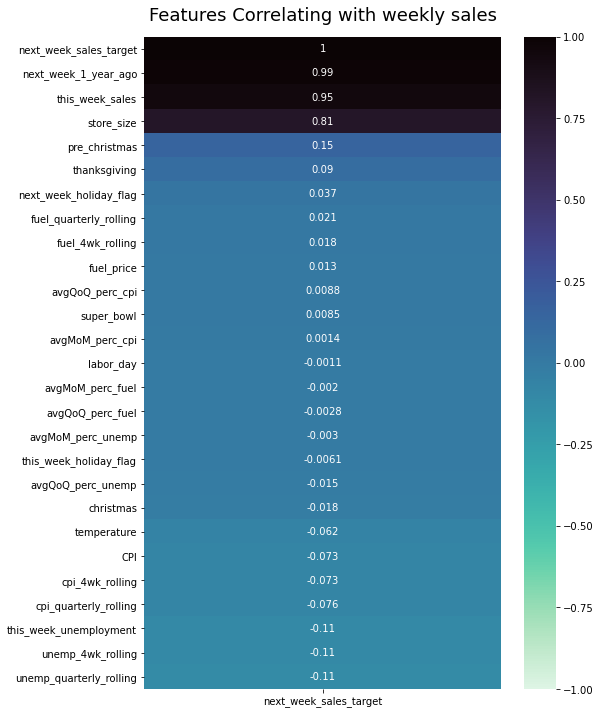

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['next_week_sales_target']].sort_values(by='next_week_sales_target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with weekly sales', fontdict={'fontsize':18}, pad=16);

<hr style="border:2px solid black"> </hr>

## Hypothesis 1: Pearson's (cont vs cont)
$H_0$: There is no correlation between next week sales and store_size

$H_a$: There is a correlation between next week sales and store_size


In [20]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [21]:
x= train.next_week_sales_target
y= train.store_size

In [22]:
r, p = stats.pearsonr(x,y)
r,p

(0.8266920637985677, 0.0)

In [23]:
p < alpha

True

In [24]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.826692 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between next week sales and store size

<hr style="border:1px solid black"> </hr>

## Hypothesis 2: Pearson's (cont vs cont)
$H_0$: There is no correlation between this week sales and next week sales

$H_a$: There is a correlation between this week sales and next week sales

In [25]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

x= train.next_week_sales_target
y= train.this_week_sales

In [26]:
r, p = stats.pearsonr(x,y)
r,p

(0.9627654091073827, 0.0)

In [27]:
p < alpha

True

In [28]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.962765 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between this week sales and next week sales.

<hr style="border:1px solid black"> </hr>

## Hypothesis 3: Pearson's (cont vs cont)
$H_0$: There is no correlation between this week sales and sales from this time last year

$H_a$: There is a correlation between this week sales and sales from this time last year

In [29]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [30]:
x= train.next_week_sales_target
y= train.next_week_1_year_ago

In [31]:
r, p = stats.pearsonr(x,y)
r,p

(0.9868949181448758, 0.0)

In [32]:
p < alpha

True

In [33]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.986895 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between this week sales and sales from this week last year.

<hr style="border:1px solid black"> </hr>

## Hypothesis 3: T-Test (discrete vs cont)
$H_0$: There is no relationship between this next_weeks_sales_target and pre_christmas

$H_a$: There is a relationship between this next_weeks_sales_target and pre_christmas

In [34]:
#set alpha
alpha = .05

In [35]:
# sample size, must be more then 30 to meet assumption
train.next_week_sales_target.count(), train.pre_christmas.count()

(2866, 2866)

In [36]:
#check variance
train.next_week_sales_target.var(), train.pre_christmas.var()

#this shows not equal varient

(311994305524.36316, 0.02050397693850634)

In [37]:
#t-test on entire train set
t, p = stats.ttest_ind(train.next_week_sales_target,train.pre_christmas, equal_var=False)
t, p

(100.85573231815083, 0.0)

In [38]:
p <alpha

True

In [39]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we reject our null hypothesis')

We calculate a t of 100.855732 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between next week sales and pre-christmas.

<hr style="border:2px solid black"> </hr>

# Modeling

In [40]:
train, test, X_train_scaled, X_test_scaled, y_train, y_test= w.split_scale(df, 'next_week_sales_target', scaler= MinMaxScaler())

train -> (2866, 32)
test -> (1229, 32)


In [41]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['store_size', 'this_week_unemployment', 'next_week_1_year_ago', 'this_week_sales', 'pre_christmas']

In [42]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_test = pd.DataFrame({'actual': y_test})

## Baseline

In [43]:
#create the baseline using mean of all sales
baseline= y_train['actual'].mean()

In [44]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [45]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [46]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': "Baseline (using mean)",
    'rmse_train': round(rmse_baseline_train, 2),
    'r^2_train': round(explained_variance_score(y_train.actual, y_train.baseline),4),

}])

metric_df

,model,rmse_train,r^2_train
0,Baseline (using mean),558467.05,0.0


## Baseline 2

In [47]:
#baseline version 2 using last years sales
baseline2 = train['next_week_1_year_ago']

In [48]:
#prediction
#create column called baseline to compare
y_train['last_year_baseline'] = baseline2

In [49]:
#calculate RMSE for baseline model
rmse_baseline2_train= math.sqrt(mean_squared_error(y_train.actual, y_train.last_year_baseline))

In [50]:
#create a dataframe to make data easier to visualize/understand
metric_df = metric_df.append(
    {
    'model': "Baseline (using last year's sales)",
    'rmse_train': round(rmse_baseline2_train, 2),
    'r^2_train': round(explained_variance_score(y_train.actual, y_train.last_year_baseline),4),
    }, ignore_index=True)

metric_df

,model,rmse_train,r^2_train
0,Baseline (using mean),558467.05,0.0000
1,Baseline (using last year's sales),91145.28,0.9738


## OLS Model

In [51]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train_scaled[features], y_train.actual)

LinearRegression(normalize=True)

In [52]:
# predict train
y_train['sales_pred_lm'] = model1.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lm)**(1/2)

In [53]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 2),
    'r^2_train': round(explained_variance_score(y_train.actual, y_train.sales_pred_lm),4),
    }, ignore_index=True)

metric_df

,model,rmse_train,r^2_train
0,Baseline (using mean),558467.05,0.0000
1,Baseline (using last year's sales),91145.28,0.9738
2,Model 1: OLS,74358.31,0.9823


## Lasso Lars

In [54]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train_scaled[features], y_train.actual)

# predict train
y_train['sales_pred_lars'] = model2.predict(X_train_scaled[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lars)**(1/2)

In [55]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,2),
    'r^2_train': round(explained_variance_score(y_train.actual, y_train.sales_pred_lars),4),
    }, ignore_index=True)

metric_df

,model,rmse_train,r^2_train
0,Baseline (using mean),558467.05,0.0000
1,Baseline (using last year's sales),91145.28,0.9738
2,Model 1: OLS,74358.31,0.9823
3,Model 2: LassoLars (alpha 2),74358.54,0.9823


## Polynomial Regression

In [56]:
#make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train_scaled[features])

In [57]:
#create the model
lm2 = LinearRegression(normalize=True)

#fit the mode
lm2.fit(X_train_degree2, y_train.actual)

#use the model
y_train['sale_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_model3 = mean_squared_error(y_train.actual, y_train.sale_pred_lm2) ** (1/2)

In [58]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,2),
    'r^2_train': round(explained_variance_score(y_train.actual, y_train.sale_pred_lm2),4),
    }, ignore_index=True)

metric_df

,model,rmse_train,r^2_train
0,Baseline (using mean),558467.05,0.0000
1,Baseline (using last year's sales),91145.28,0.9738
2,Model 1: OLS,74358.31,0.9823
3,Model 2: LassoLars (alpha 2),74358.54,0.9823
4,Model 3: Polynomial Regression (degree=2),69784.81,0.9844


### Takeaways
- Data was scaled using MinMaxScaler
- Features included for modeling were: 'store_size', 'this_week_unemployment', 'next_week_1_year_ago', 'this_week_sales', and 'pre_christmas'

<br>

- 2nd Degree Polynomial Regression model out performed the baseline (using last year's sales) by 23.44% on the train set

<hr style="border:2px solid black"> </hr>

## Use Polynomial Regression on Test Set